# Import Relevant Libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.pyplot import figure
import matplotlib
import numpy as np
from scipy.special import sph_harm as spherical
from scipy.special import lpmv as legendre
from scipy.signal import savgol_filter
import glob
from scipy.signal import correlate
#from scipy.signal import correlation_lags
from scipy.ndimage import correlate as incorrelate
from scipy.signal import fftconvolve
from scipy.interpolate import interp1d
import pickle
import astropy.constants as const
from scipy import integrate
from scipy.signal import lombscargle
import numba
from numba import jit
import scipy as scipy
from scipy.fft import fft, fftfreq
import random
#import PyAstronomy 

c = 2.99e8
pi = np.pi
loc0 = '/data/bleblanc/MastersMESA/Jupiter/0Me_core/summary/'

# Assign array values

In [2]:
m0core_J_l0 = np.genfromtxt(loc0 + 'summary_l0_nocoreJupiter.txt',usecols=(2),skip_header=6)
m0core_J_l1 = np.genfromtxt(loc0 + 'summary_l1_nocoreJupiter.txt',usecols=(2),skip_header=6)
m0core_J_l2 = np.genfromtxt(loc0 + 'summary_l2_nocoreJupiter.txt',usecols=(2),skip_header=6)
m0core_J_l3 = np.genfromtxt(loc0 + 'summary_l3_nocoreJupiter.txt',usecols=(2),skip_header=6)
m0core_J_l0 *= 100
m0core_J_l1 *= 100
m0core_J_l2 *= 100
m0core_J_l3 *= 100

# Run code to generate Picket Plot

[ 1.3520938   3.64360498  5.71234071  7.31651765  8.88987356 10.57449199
 12.03196767 13.61502632 15.12007107 16.63675586 18.15209107 19.6622623
 21.18033307 22.66834809 24.18226257 25.69732406 27.20235569 28.703211
 30.21750758 31.73930482 33.24739359 34.76306353 36.27788008 37.80493236
 39.32352042 40.84187092 42.36819137 43.89512567 45.41871654 46.94581745
 48.4751503  50.00552921]
[ 135.20937996  364.3604983   571.23407135  731.6517652   888.98735641
 1057.44919851 1203.1967669  1361.50263247 1512.00710728 1663.67558619
 1815.20910672 1966.22622999 2118.03330662 2266.83480861 2418.22625692
 2569.73240553 2720.23556892 2870.32109981 3021.75075842 3173.93048189
 3324.7393594  3476.30635288 3627.78800754 3780.49323593 3932.35204221
 4084.18709157 4236.81913662 4389.51256662 4541.871654   4694.58174546
 4847.51503011 5000.55292119]


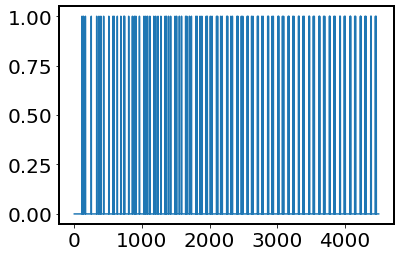

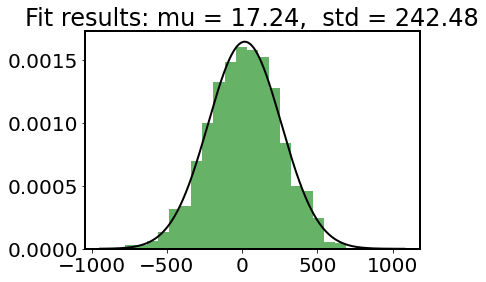

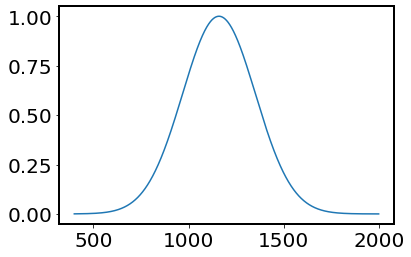

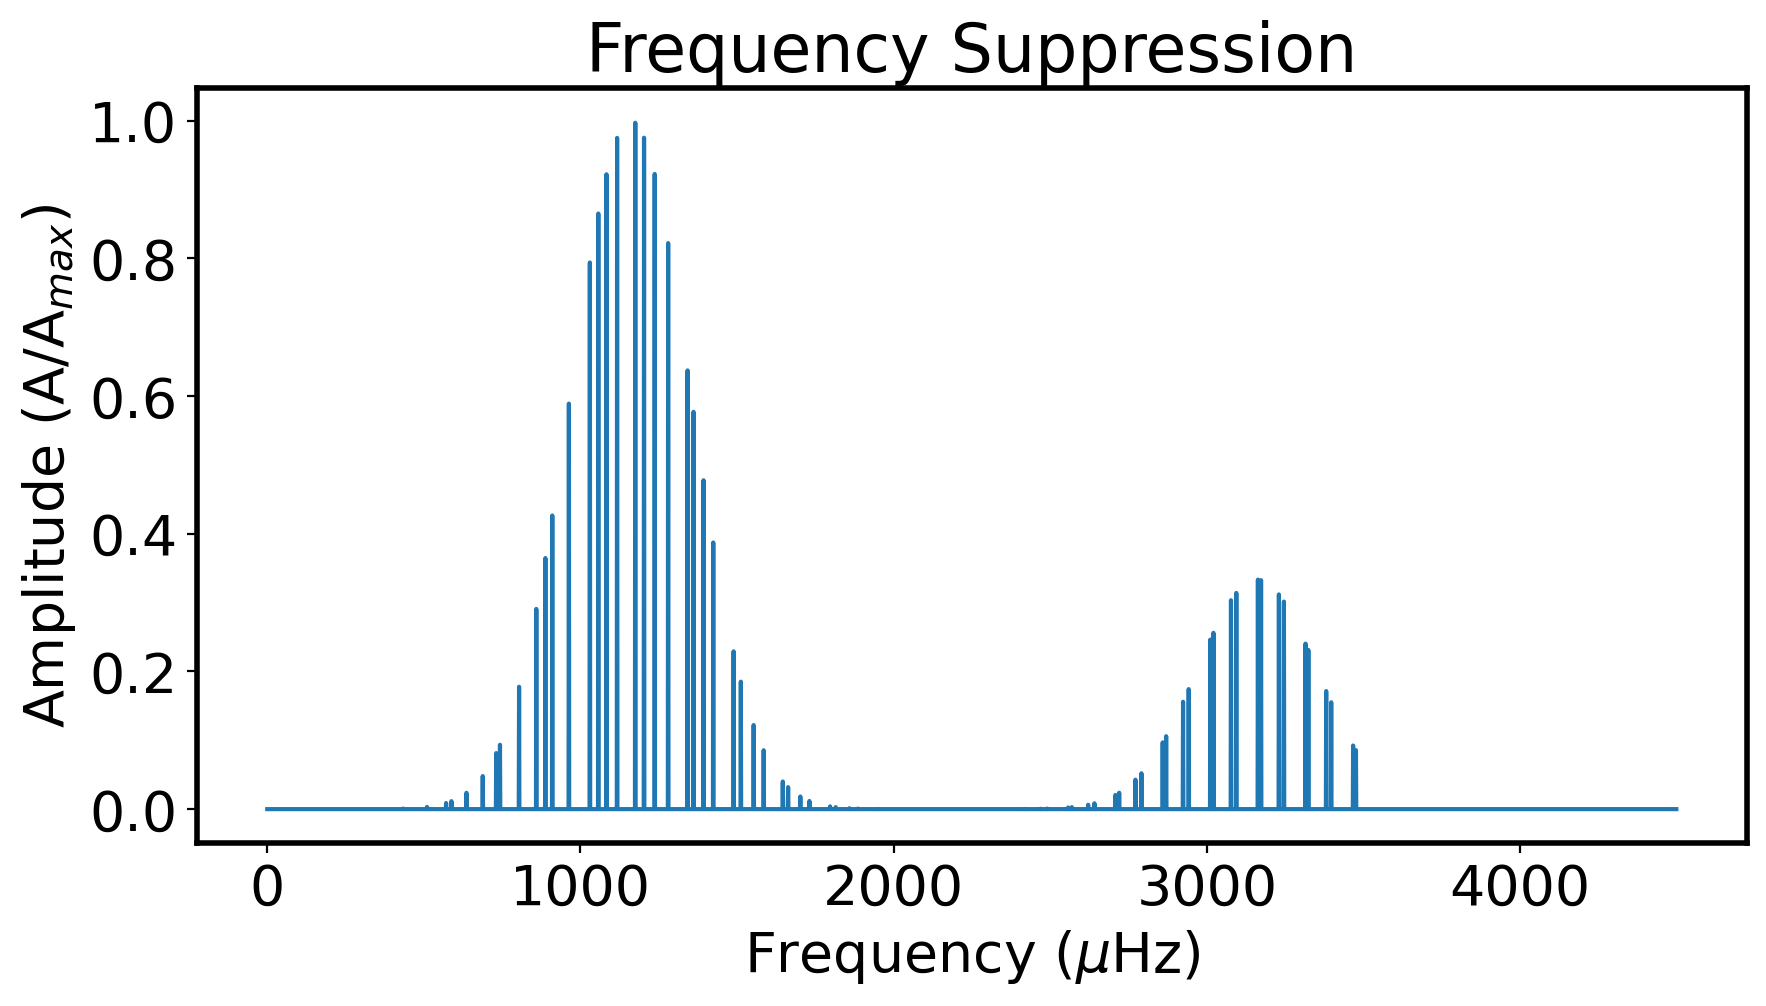

In [75]:
%run PicketPlot.ipynb

In [270]:
diff=[]
for i in range(len(freq)-1):
    if peak[i] != 0:
        diff.append(i)
print(diff)
holder = 100000
for i in range(len(diff)-1):
    if abs(diff[i] - diff[i+1]) < holder:
        holder=abs(diff[i] - diff[i+1])
#print(holder)

[434, 510, 571, 588, 636, 688, 731, 743, 804, 859, 888, 910, 963, 1030, 1057, 1083, 1117, 1175, 1203, 1237, 1280, 1342, 1361, 1393, 1424, 1489, 1512, 1553, 1585, 1646, 1663, 1702, 1731, 1797, 1815, 1859, 1886, 1950, 1966, 2405, 2418, 2469, 2490, 2557, 2569, 2621, 2641, 2708, 2720, 2772, 2791, 2859, 2870, 2924, 2942, 3011, 3021, 3077, 3094, 3163, 3173, 3230, 3246, 3315, 3324, 3381, 3397, 3467, 3476]
9


# Change arrays to be defined by spherical degree l

In [212]:
l0 = []
for i in range(len(m0core_J_l0)):
    if m0core_J_l0[i] < len(picket):
        l0.append(m0core_J_l0[i])

l1 = []
for i in range(len(m0core_J_l1)):
    if m0core_J_l1[i] < len(picket):
        l1.append(m0core_J_l1[i])

l2 = []
for i in range(len(m0core_J_l2)):
    if m0core_J_l2[i] < len(picket):
        l2.append(m0core_J_l2[i])
        
l3 = []
for i in range(len(m0core_J_l3)):
    if m0core_J_l3[i] < len(picket):
        l3.append(m0core_J_l3[i])
        
l3, l2, l1, l0 

([164.0111040318952,
  393.09694792575607,
  588.7853230156813,
  743.1594741569461,
  910.4142666645408,
  1083.844871916402,
  1237.548880183271,
  1393.21570235307,
  1553.167184623393,
  1702.629433146828,
  1859.7346731673842],
 [114.676599601004,
  331.6551376835161,
  510.64761693268457,
  688.3117655751312,
  859.6969398604836,
  1030.710301091982,
  1175.285829821132,
  1342.051166657323,
  1489.970017786993,
  1646.7225488327301,
  1797.599930626674,
  1950.722737683553],
 [251.86346645416958,
  434.2802263407391,
  636.0206406224239,
  804.0989161176959,
  963.4233119116521,
  1117.291563992835,
  1280.3094046133078,
  1424.903761839334,
  1585.280330385058,
  1731.067341465013,
  1886.304271367345],
 [135.2093799605352,
  364.3604983020663,
  571.2340713518412,
  731.6517651989277,
  888.9873564080397,
  1057.449198507654,
  1203.196766896862,
  1361.502632471778,
  1512.007107281019,
  1663.675586189235,
  1815.2091067172041,
  1966.226229994901])

# Generate the grid

In [78]:
# Set the max for the hemispheral grid
ymax = 2*pi; ymin = 0; xmax = pi; xmin = 0
numsamp = 100 # grid resolution

# Generate grid
phi = np.linspace(xmin,xmax,numsamp)
theta = np.linspace(ymin,ymax,numsamp)
grid_phi, grid_theta = np.meshgrid(phi,theta)

# Set the amplitude of the expected radial velocity
velamp = 1 #m/s

# Spherical order and degree
degree = [0,1,2,3]
order = np.arange(-3,4,1)
#order = [0]
# Centre of hemisphere
#cen = np.random.rand()*2*pi
cen = pi-0.1
print('Hemisphere = ', cen-pi, cen+pi)

# Time series
night = 8*3600 # seconds/night
time = np.arange(30, night, 30) # 30 seconds for each SPIRou observation
ftime = np.linspace(0,night,night)

vel = []
velocity = np.empty(len(time))

sine = np.empty((1,25,len(time)))
series = np.empty((1,25,len(time)))
# the time series of spherical harmonics: for a given a,b there is a sine wave
# for a given time i there is a disk projection
t_sph = np.zeros((numsamp,numsamp,len(time)))
ft_sph = np.zeros((numsamp,numsamp,len(ftime)))
avg = np.zeros((numsamp,numsamp))
len(time)

Hemisphere =  -0.10000000000000009 6.183185307179587


959

# Determine the length of the projection on r

In [79]:
phi_len = np.empty((numsamp,numsamp))
theta_len = np.empty((numsamp,numsamp))
r = np.empty((numsamp,numsamp))
for a in range(numsamp):
        for b in range(numsamp):
            phi_len[a,b] = phi[a] - pi/2
            theta_len[a,b] = np.min([(abs(theta[b] - cen)),(abs(theta[b] + 2*pi - cen))])
            # length of projected r vector
            r[a,b] = np.sqrt(phi_len[a,b]**2 + theta_len[a,b]**2)
            # periodicity
            if r[a,b] > pi:
                r[a,b] = 2*pi - r[a,b]
                
r

array([[2.85992853, 2.91619312, 2.97219727, ..., 2.79484679, 2.73806375,
        2.6810576 ],
       [2.87437305, 2.93088007, 2.98713376, ..., 2.80902071, 2.75200974,
        2.69478203],
       [2.88858238, 2.94532994, 3.00183134, ..., 2.82296166, 2.76572473,
        2.70827746],
       ...,
       [2.88858238, 2.94532994, 3.00183134, ..., 2.82296166, 2.76572473,
        2.70827746],
       [2.87437305, 2.93088007, 2.98713376, ..., 2.80902071, 2.75200974,
        2.69478203],
       [2.85992853, 2.91619312, 2.97219727, ..., 2.79484679, 2.73806375,
        2.6810576 ]])

# Spherical Harmonic Calculation

In [80]:
spherical_calc = []
#x=0
for l in range(len(degree)):
    for m in range(len(order)):
        if abs(order[m]) <= degree[l]:
            spherical_calc.append(spherical(order[m], degree[l], grid_theta, grid_phi).real)

# Perform disk integration over pre-defined grid

In [81]:
@jit(nopython=True)
def DiskIntegration(order,degree,m0core_J_l0,m0core_J_l1,m0core_J_l2,m0core_J_l3,picket,spherical_calc,r,numsamp,l0,l1,l2,l3):

    k, q, n, x = 0, 0, 0, -1
    
    night = 8*3600 # seconds/night
    time = np.arange(30, night, 30) # 30 seconds for each SPIRou observation
    ftime = np.linspace(0,night,night)
    t_sph = np.zeros((numsamp,numsamp,len(time)))
    ft_sph = np.zeros((numsamp,numsamp,len(ftime)))
    #avg = np.zeros((numsamp,numsamp))
    
    for l in range(len(degree)):
        for m in range(len(order)):
            if abs(order[m]) <= degree[l]:
                # choose the GYRE file
                if degree[l] == 0:
                    #f = m0core_J_l0
                    f = l0*1
                    print(f)
                elif degree[l] == 1:
                    #f = m0core_J_l1
                    f = l1*1
                    print(f)
                elif degree[l] == 2:
                    #f = m0core_J_l2
                    f = l2*1
                    print(f)
                elif degree[l] == 3:
                    #f = m0core_J_l3
                    f = l3*1
                    print(f)
                
                print('l = ',degree[l], ', m = ',order[m])

                
                x += 1
                
                # for each frequency dependent on n
                for n in range(len(f)):

                    # Determine time series
                    # where f is in uHz from GYRE 
                    offset = np.random.uniform(0,2*pi)
                    w = 2*pi*(f[n]/1e6)
                    
                    # add phase offset
                    sf = np.sin(w*ftime+(offset))

                    # in the time series
                    for i in range(len(sf)):
                        sph_n = spherical_calc[x]*1
                        #sph_n = scipy.special.sph_harm(order[m], degree[l], grid_theta, grid_phi).real
                        
                        # Normalize and multiply by freq and picket
                        sph_max = np.max(sph_n)
                        sph_n = (sph_n/(sph_max))*picket[int(f[n])]*sf[i] 

                        # in the grid 
                        for a in range(numsamp):
                            for b in range(numsamp):
                                
                                # project on the plane
                                if r[a,b] < pi/2:
                                    sph_n[a,b] = sph_n[a,b]*np.cos(r[a,b])#+ random.gauss(sph_n[a,b],0.67) #(mu,sigma)
                                else:
                                    sph_n[a,b] = 0
                                # When the above is commented out, the full hemisphere is plotted

                                ft_sph[a,b,i] += sph_n[a,b] 

    return ft_sph

In [82]:
ft_sph = DiskIntegration(order,degree,m0core_J_l0,m0core_J_l1,m0core_J_l2,m0core_J_l3,picket,spherical_calc,r,numsamp,l0,l1,l2,l3)

/usr/local/lib64/python3.7/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'degree' of function 'DiskIntegration'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-81-60bea64ec64a>", line 2:
@jit(nopython=True)
def DiskIntegration(order,degree,m0core_J_l0,m0core_J_l1,m0core_J_l2,m0core_J_l3,picket,spherical_calc,r,numsamp,l0,l1,l2,l3):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib64/python3.7/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'l0' of function 'DiskIntegration'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#de

[135.2093799605352, 364.3604983020663, 571.2340713518412, 731.6517651989277, 888.9873564080397, 1057.449198507654, 1203.196766896862, 1361.502632471778, 1512.007107281019, 1663.675586189235, 1815.2091067172041, 1966.226229994901]
l =  0 , m =  0
[251.86346645416958, 434.2802263407391, 636.0206406224239, 804.0989161176959, 963.4233119116521, 1117.291563992835, 1280.3094046133078, 1424.903761839334, 1585.280330385058, 1731.067341465013, 1886.304271367345]
l =  1 , m =  -1
[251.86346645416958, 434.2802263407391, 636.0206406224239, 804.0989161176959, 963.4233119116521, 1117.291563992835, 1280.3094046133078, 1424.903761839334, 1585.280330385058, 1731.067341465013, 1886.304271367345]
l =  1 , m =  0
[251.86346645416958, 434.2802263407391, 636.0206406224239, 804.0989161176959, 963.4233119116521, 1117.291563992835, 1280.3094046133078, 1424.903761839334, 1585.280330385058, 1731.067341465013, 1886.304271367345]
l =  1 , m =  1
[114.676599601004, 331.6551376835161, 510.64761693268457, 688.3117655

# Generate map of hemisphere

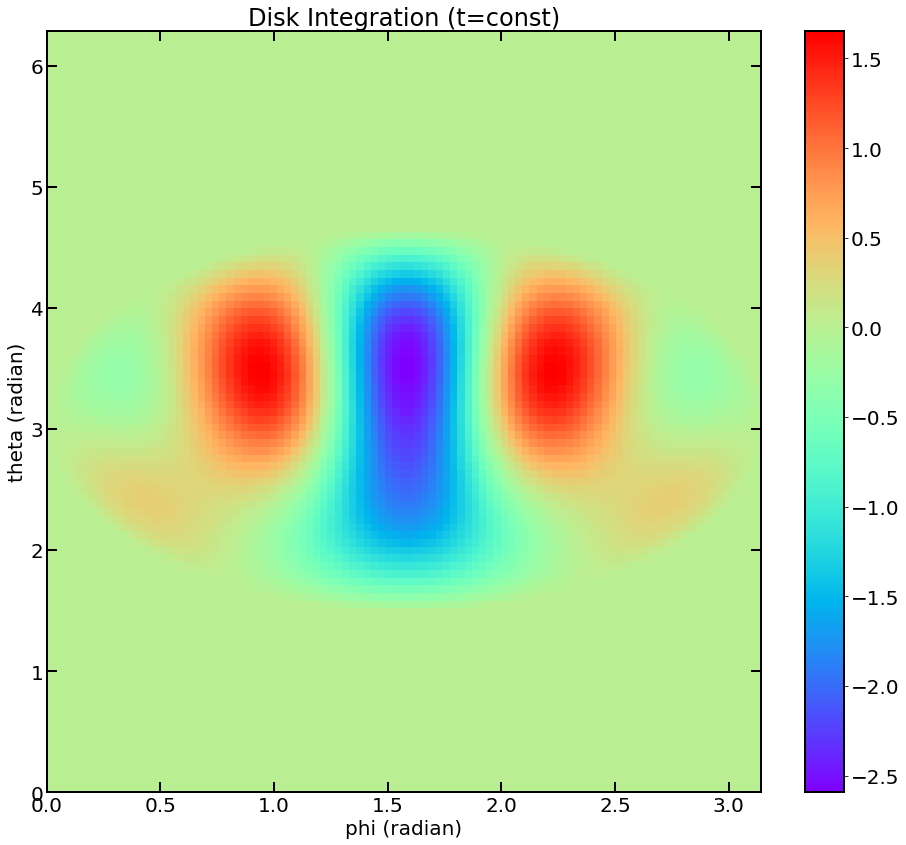

In [215]:
cmap = plt.get_cmap('rainbow')
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig=plt.figure(figsize=(16,14)) #adjust size of figure
ax = plt.axes()

ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2)
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2)


ax.set_xlabel('phi (radian)')
ax.set_ylabel('theta (radian)')
ax.set_title('Disk Integration (t=const)')

ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

im=ax.pcolormesh(phi,theta,ft_sph[:,:,250].T,cmap=cmap)
#fig.savefig('everyseconddiskintegration.pdf')
fig.colorbar(im)
fig.show()

# Examine single point on surface through a full night's observation

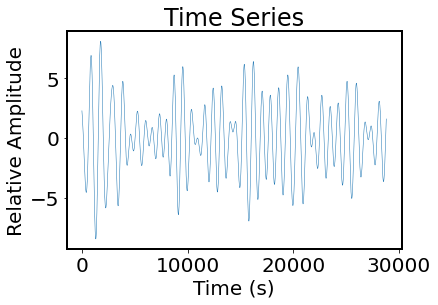

In [85]:
plt.plot(ftime,ft_sph[50,50,:],linewidth=0.5)

plt.title('Time Series')
plt.xlabel('Time (s)')
plt.ylabel('Relative Amplitude')
#plt.savefig('TimeSeriesEverySecond.pdf')
plt.show()

In [86]:
for x in range(len(time)):
    for a in range(numsamp):
        for b in range(numsamp):
            p = x*30
            p1 = (x+1)*30
            #t_sph_1jit[a,b,x] = np.mean(ft_sph_1jit[a,b,p:p1])
            t_sph[a,b,x] = np.mean(ft_sph[a,b,p:p1])

# Generate secondary map

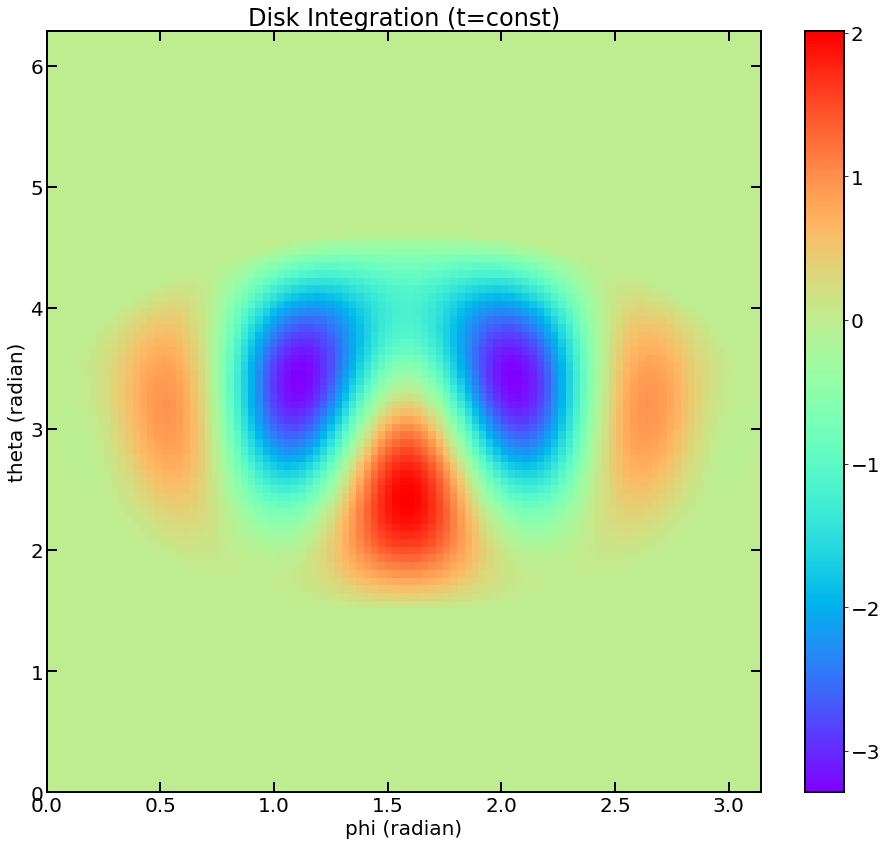

In [150]:
cmap = plt.get_cmap('rainbow')
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig=plt.figure(figsize=(16,14)) #adjust size of figure
ax = plt.axes()

ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2)
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2)


ax.set_xlabel('phi (radian)')
ax.set_ylabel('theta (radian)')
ax.set_title('Disk Integration (t=const)')

ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

im=ax.pcolormesh(phi,theta,t_sph[:,:,352].T,cmap=cmap)
fig.colorbar(im)
fig.savefig('DiskIntegration30secsum.pdf')
fig.show()

# Add jitter as simulated noise

In [168]:
#coadd_1jit = np.empty(len(t_sph_1jit[0,0]))
coadd_1jit = np.empty(len(t_sph[0,0]))

coadd_set = np.empty((10,len(t_sph[0,0])))
for i in range(len(coadd_set)):
    for t in range(len(t_sph[0,0])):    
        coadd_set[i,t] = np.mean(t_sph[:,:,t])
        coadd_set[i,t] += random.gauss(coadd_set[i,t],i*0.5*0.67) #i increases by 0.5 so we increase jitter by 0.5m/s per
        

# Time series of coadded surface of entire hemisphere for 1 night obersvation

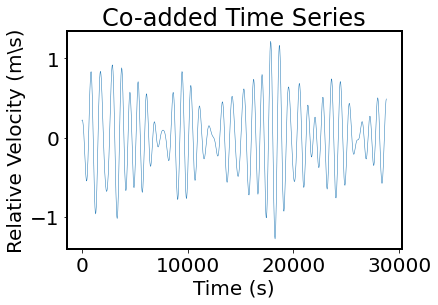

In [181]:
plt.plot(time,coadd_set[0],linewidth=0.5)
plt.title('Co-added Time Series')
plt.xlabel('Time (s)')
plt.ylabel('Relative Velocity (m\s)')
plt.savefig('CoaddedTimeSeries.pdf',bbox_inches='tight')
plt.show()

# FFT from scipy

In [165]:
xf,yf = [], []
for i in range(len(coadd_set)):
# Number of sample points
    N = len(coadd_set[i])
    # sample spacing
    T = 1/30 #s from spacing of coadd array

    y = coadd_set[i]
    yf.append(fft(y))
    xf.append(fftfreq(N, T)[:N//2])
    #xf = fftfreq(N,T)

# Time Series with increasing jitter (noise)

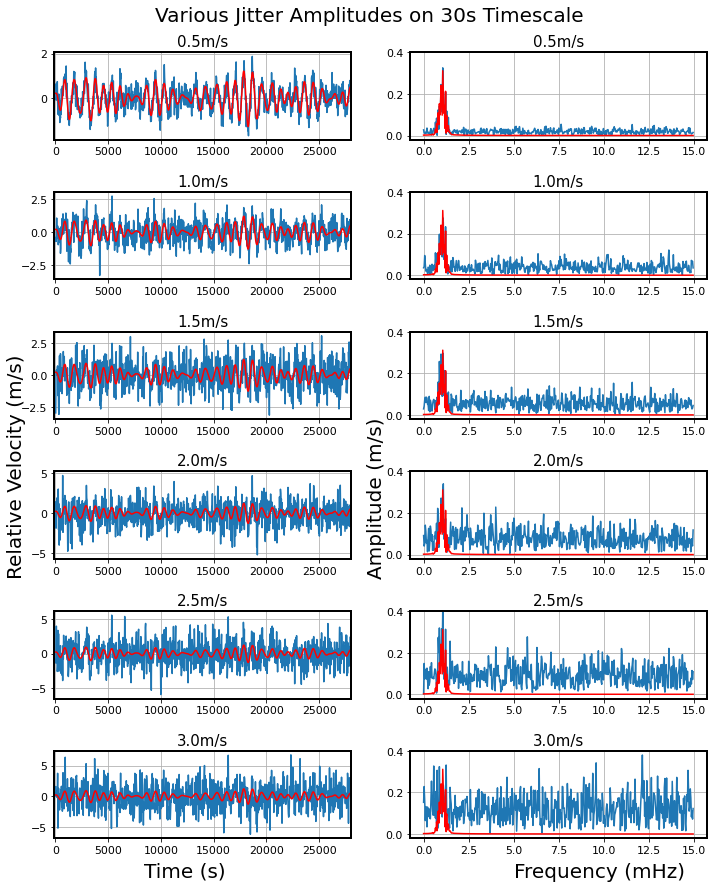

In [206]:
fig, axs = plt.subplots(len(coadd_set)-4,2)

for i in range(1,len(coadd_set)-3):  
    axs[i-1,1].plot(xf[i], 2.0/N * np.abs(yf[i][0:N//2]))
    #axs[i,1].set_title(str(i*0.5) + 'm/s',fontsize=15)
    axs[i-1,1].plot(xf[0], 2.0/N * np.abs(yf[0][0:N//2]),c='r')
    axs[i-1,1].grid()
    axs[i-1,1].tick_params(axis='x', labelsize=11 )
    axs[i-1,1].tick_params(axis='y', labelsize=11 )
    axs[i-1,1].set_title(str(i*0.5) + 'm/s',fontsize=15)
    axs[i-1,1].set_ylim(-0.02,0.4)
for i in range(1,len(coadd_set)-3):  
    axs[i-1,0].plot(time,coadd_set[i])
    axs[i-1,0].set_title(str(i*0.5) + 'm/s',fontsize=15)
    axs[i-1,0].plot(time,coadd_set[0],c='r')
    axs[i-1,0].tick_params(axis='x', labelsize=11 )
    axs[i-1,0].tick_params(axis='y', labelsize=11 )
    axs[i-1,0].set_xlim(-100,28000)
    axs[i-1,0].grid()
    
    
fig.text(0.5, 0.99, 'Various Jitter Amplitudes on 30s Timescale', ha='center',fontsize=20)
fig.text(0.7, 0.00, 'Frequency (mHz)', ha='left')
fig.text(0.3, 0.00, 'Time (s)', ha='right')
fig.text(0.01, 0.35, 'Relative Velocity (m/s)', rotation = 'vertical', ha='center')
fig.text(0.51, 0.35, 'Amplitude (m/s)', rotation = 'vertical', ha='center')
fig.set_size_inches(10,12)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.6)
fig.savefig('SequentialJitter.pdf',bbox_inches='tight')
fig.show()

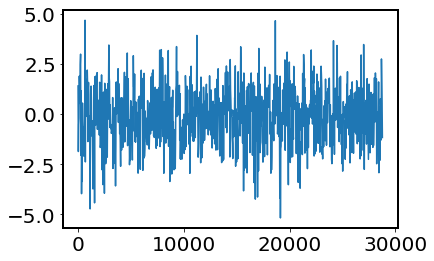

In [207]:
plt.plot(time,coadd_set[4])
plt.show()

In [214]:
with open('TimeSeriesJitter2ms.txt', 'w') as f:
    for i in range(len(coadd_set[4])):
        f.write(str(coadd_set[4,i]))
        f.write('  ')
        f.write(str(time[i]*(1/(24*3600))))
        f.write('\n')

In [210]:
with open('Time.txt', 'w') as f:
    for i in range(len(time)):
        f.write(str(time[i]))
        f.write('\n')

# Fourier Transform example from previous time series data

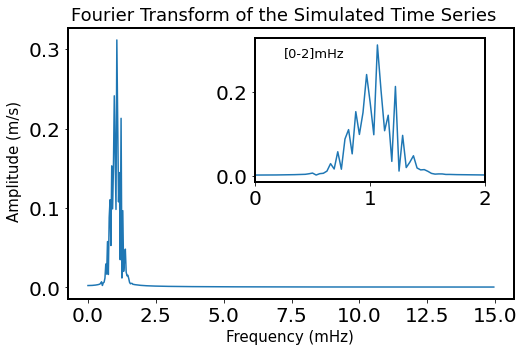

In [264]:
from matplotlib.gridspec import GridSpec
# fig, axs = plt.subplots(2)

fig = plt.figure(figsize=(8, 5))
gs = GridSpec(nrows=1, ncols=1)

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(xf[0], 2.0/N * np.abs(yf[0][0:N//2]))

ax3 = fig.add_axes([0.45, 0.45, 0.4, 0.4])
ax3.plot(xf[0], 2.0/N * np.abs(yf[0][0:N//2]))
ax3.set_xlim(0,2)

# ax0.plot(xf[0], 2.0/N * np.abs(yf[0][0:N//2]))
fig.text(0.5, 0.9, r'Fourier Transform of the Simulated Time Series',fontsize=18,ha='center')
fig.text(0.02,0.35,'Amplitude (m/s)',rotation = 'vertical',fontsize=15)
fig.text(0.4,0.01,'Frequency (mHz)',fontsize=15)
fig.text(0.5,0.8, r'[0-2]mHz',fontsize=13)
# #ax.xlim(0,2)
# ax1 = add_axes([0.6, 0.6, 0.2, 0.2])
# ax1.plot(xf[0], 2.0/N * np.abs(yf[0][0:N//2]))

plt.savefig('FT_coadd_zoom.pdf',bbox_inches='tight')
plt.show()